In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pckgs.helper import reduce
from pckgs.models import get_model_mlp, get_model_single_lstm, \
    train_model, get_model_both_sent, get_model_both_emb, get_model_cnn
from pckgs.price_preprocess import PricePreprocess
from fin_utils.labels import oracle_labels
import math
from pckgs.evaluator import Evaluator
import numpy as np
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
candle = pd.read_feather('./Price/datasets/coinbase_day_candles/BTC-USD.feather')
# candle = pd.read_feather('./Price/datasets/coinbase_hour_candles/BTC-USD.feather')
candle.set_index('time', inplace=True)

In [3]:
# plt.figure(figsize=(10,8))
# sb.lineplot(data=candle, x=candle.index, y='close')
# oracle_labels(candle, 0.005, include_exit=True)

In [28]:
start_timestamp = '2015-01-01 00:00:00'
split_timestamp = '2019-01-30 00:00:00'
end_timestamp = '2019-12-31 23:00:00'

lag = 21
# threshold = 0.5
threshold = 0.7
pp = PricePreprocess(lag, threshold)

In [29]:
#reduce candle
positions = pp.preprocess(candle)

In [30]:
#train test split
y = positions.loc[:, ['down', 'same', 'up']]
x = positions.drop(['down', 'same', 'up'], axis=1)

# sentiment = pd.read_csv('./Text/datasets/headline_sentiment_mean.csv', index_col='date', parse_dates=['date'])
# sentiment_score = reduce(sentiment, lag=21)
# sentiment_score.dropna(inplace=True)
# sentiment_score.drop('sentiment_score_t', axis=1, inplace=True)
# x2 = sentiment_score
# x=x2
# x = x2.merge(x, left_index=True, right_index=True, how='right').dropna()


x_train = x.loc[(start_timestamp <= x.index) & (x.index <= split_timestamp)]
y_train = y.loc[(start_timestamp <= y.index) & (y.index <= split_timestamp)]
x_test = x.loc[(split_timestamp < x.index) & (x.index <= end_timestamp)]
y_test = y.loc[(split_timestamp < y.index) & (y.index <= end_timestamp)]
y_train.value_counts()
y_test.value_counts()

# x_train = x_train.values.reshape((len(x_train), int(len(x_train.columns) / 2), 2), order='F')
# x_test = x_test.values.reshape((len(x_test), int(len(x_test.columns) / 2), 2), order='F')


test_index = y_test.index
test_candle = candle.reindex(test_index)

down  same  up
0     0     1     582
      1     0     462
1     0     0     447
dtype: int64

down  same  up
0     0     1     126
1     0     0     113
0     1     0      96
dtype: int64

In [7]:
def evaluate(y_test, y_pred):
    #create labeled y_test to measure pnl, confusion matrix
    y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
    y_test_labeled = y_test_labeled.idxmax(axis=1)

    y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1])
    y_pred_labeled = y_pred_labeled.idxmax(axis=1)

    report = classification_report(y_test_labeled, y_pred_labeled,output_dict=True)
    return report['accuracy']
    # print(report['accuracy'])
    # print(report['macro avg']['f1-score'])
    # print(report['weighted avg']['f1-score'])


In [14]:
x_test.shape
#loop
# model = get_model_mlp()
model = get_model_single_lstm()
# model = get_model_cnn()
# model.summary()
# model = get_model_both_sent()
model, model_pnl, history, pnl = train_model(model, (x_train, x_test, y_train, y_test),test_candle, './model_price.h5', epochs=4000)
# y_pred = model.predict(x_test)
# evaluate(y_test, y_pred)

(335, 20)

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

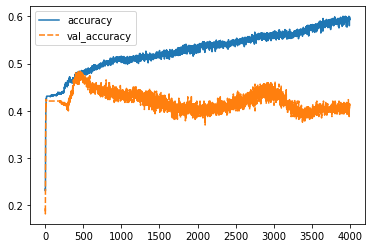

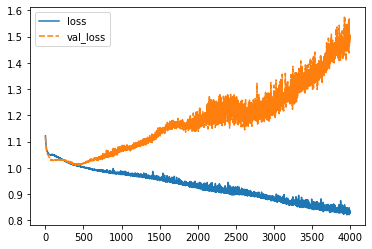

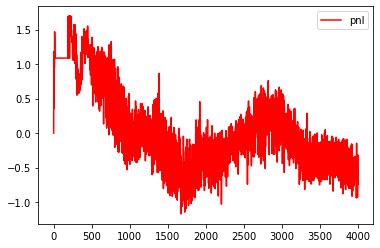

In [15]:
#plot learning curve
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

plt.figure()
sb.lineplot(data=pnl,label='pnl', color='red')

In [ ]:
# y_pred = model.predict(x_test)
y_pred = model_pnl.predict(x_test)


y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=test_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

# pnl = Evaluator.get_pnl(y_pred_labeled, test_candle)
# pnl.iloc[len(pnl) - 1]

# Evaluator.evaluate(y_pred_labeled, y_test_labeled, test_candle)
# print(classification_report(y_test_labeled, y_pred_labeled))